## Iceberg Classifier Submission

### DataLoader

In [ ]:
%%capture
!pip install xgboost
!pip install hyperopt
!pip install py7zr
!pip install albumentations
!pip install lightgbm
#!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import os

# Kaggle configuration
os.environ["KAGGLE_CONFIG_DIR"] = "/content/gdrive/My Drive/Kaggle"
MAIN_DIR = "/content/gdrive/My Drive/Kaggle"
os.chdir(MAIN_DIR)

# download data
!kaggle competitions download -c statoil-iceberg-classifier-challenge

In [ ]:
!unzip /content/gdrive/MyDrive/Kaggle/statoil-iceberg-classifier-challenge.zip

Archive:  /content/gdrive/MyDrive/Kaggle/statoil-iceberg-classifier-challenge.zip
  inflating: sample_submission.csv.7z  
  inflating: test.json.7z            
  inflating: train.json.7z           


In [ ]:
test_path = "/content/gdrive/MyDrive/Kaggle/test.json.7z"
train_path = "/content/gdrive/MyDrive/Kaggle/train.json.7z"

In [ ]:
import os
#os.chdir("/content")
import py7zr

file = py7zr.SevenZipFile(test_path, mode='r')
file.extractall('.')

file = py7zr.SevenZipFile(train_path, mode='r')
file.extractall('.')

### Data Processing / Augmentation

In [ ]:
import pandas as pd
import numpy as np
import math

data_dir = "/content/data/processed"
test_data = pd.read_json(os.path.join(data_dir, "test.json"))
train_data = pd.read_json(os.path.join(data_dir, "train.json"))

In [ ]:
train_data.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",0.766617,0.0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",0.665951,0.0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",0.790388,1.0
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",0.764988,0.0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",0.621784,0.0


In [ ]:
train_data.id.nunique()

1604

In [ ]:
import collections
collections.Counter(train_data.is_iceberg)

Counter({0: 851, 1: 753})

In [ ]:
# convert and reshape bands to numpy arrays
X_band_1_train = np.array(
    [np.array(band).astype(np.float32).reshape(75,75) for band in train_data['band_1']])

X_band_2_train = np.array(
    [np.array(band).astype(np.float32).reshape(75,75) for band in train_data['band_2']])

YTrain = np.array(train_data['is_iceberg'])


In [ ]:
# convert and reshape bands to numpy arrays
X_band_1_test = np.array(
    [np.array(band).astype(np.float32).reshape(75,75) for band in test_data['band_1']])

X_band_2_test = np.array(
    [np.array(band).astype(np.float32).reshape(75,75) for band in test_data['band_2']])


In [ ]:
X_band_2_train.shape

(1604, 75, 75)

In [ ]:
#fill missing inc_anlge with mean
train_data[train_data['inc_angle']=='na'] = train_data[train_data['inc_angle']!='na']['inc_angle'].mean()
train_data['inc_angle'] = train_data['inc_angle'].apply(lambda x : math.radians(x))

#fill missing inc_anlge with mean
test_data['inc_angle'] = test_data['inc_angle'].apply(lambda x : math.radians(x))

X_train_angle = np.array(train_data['inc_angle'])
test_angle = np.array(test_data['inc_angle'])

train_data['inc_angle'].head()

0    0.766617
1    0.665951
2    0.790388
3    0.764988
4    0.621784
Name: inc_angle, dtype: float64

In [ ]:
# augument images
#### Data Augmentation
import albumentations as A

def augment_data(band_1, band_2, labels, angles):

  aug_band_1 = []
  aug_band_2 = []
  aug_label = []
  aug_angle = []

  for i in range(labels.shape[0]):

    transform = A.Compose([
        A.HorizontalFlip(p=0.9),
        A.Flip(p=0.9),
        A.Rotate(limit=25, p=0.9),
        A.VerticalFlip(p=0.9),
        A.CenterCrop(75,75, p=1),], p=1)


    transformed_band_1 = transform(image = band_1[i])
    transformed_band_2 = transform(image = band_2[i])

    aug_band_1.append(transformed_band_1["image"])
    aug_band_2.append(transformed_band_2["image"])

    aug_label.append(labels[i])
    aug_angle.append(angles[i])

  aug_band_1 = np.array(aug_band_1)
  aug_band_2 = np.array(aug_band_2)
  aug_labels = np.array(aug_label)
  aug_angles = np.array(aug_angle)

  # concatenate generated data to the original
  band1_generated = np.concatenate((aug_band_1, band_1), axis=0)
  band2_generated = np.concatenate((aug_band_2, band_2), axis=0)
  
  label_generated = np.concatenate((aug_labels, labels), axis=0)
  angle_generated = np.concatenate((aug_angles, angles), axis=0)

  return band1_generated, band2_generated, label_generated, angle_generated

In [ ]:
band_1_train, band_2_train, YTrain, train_angles = augment_data(
    X_band_1_train, X_band_2_train, YTrain, X_train_angle)

In [ ]:
''' # mao augment function to images
band_1_train_aug = np.array(list(map(augment_data, (X_band_1_train))))
band_2_train_aug = np.array(list(map(augment_data, (X_band_2_train))))

# concat augmented data to original data
X_band_1_aug = np.concatenate((X_band_1_train, band_1_train_aug), axis=0)
X_band_2_aug = np.concatenate((X_band_2_train, band_2_train_aug), axis=0) '''

In [ ]:
band_1_train[0]

array([[-28.105844, -28.738033, -28.558332, ..., -28.353867, -29.07423 ,
        -27.121317],
       [-25.666115, -27.161491, -27.129658, ..., -27.765678, -29.562567,
        -28.887262],
       [-26.540318, -25.303204, -24.360777, ..., -30.183311, -32.93804 ,
        -30.246176],
       ...,
       [-29.0778  , -28.191757, -27.53754 , ..., -29.065746, -31.17927 ,
        -31.21338 ],
       [-27.924107, -26.512068, -26.181843, ..., -28.799839, -28.698341,
        -29.12733 ],
       [-28.530588, -27.49492 , -26.141762, ..., -26.866722, -28.680359,
        -28.510788]], dtype=float32)

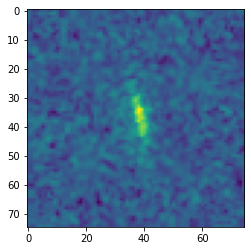

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(band_1_train[10])

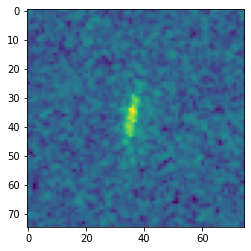

In [ ]:
plt.imshow(X_band_1_train[10])

In [ ]:
# rescale band

X_band_1_train = (band_1_train - band_1_train.mean()) / (band_1_train.max() - band_1_train.min())
X_band_2_train = (band_2_train - band_2_train.mean()) / (band_2_train.max() - band_2_train.min())

X_band_3_train = (X_band_1_train + X_band_2_train)/2


In [ ]:
# rescale band
# you don't augment test data
X_band_1_test = (X_band_1_test - X_band_1_test.mean()) / (X_band_1_test.max() - X_band_1_test.min())
X_band_2_test = (X_band_2_test - X_band_2_test.mean()) / (X_band_2_test.max() - X_band_2_test.min())

X_band_3_test = (X_band_1_test + X_band_2_test)/2

In [ ]:
XTrain = np.concatenate(
    [X_band_1_train[:, :, :, np.newaxis],
    X_band_2_train[:, :, :, np.newaxis],
    X_band_3_train[:, :, :, np.newaxis]], axis=-1,)

In [ ]:
XTest = np.concatenate(
    [X_band_1_test[:, :, :, np.newaxis],
    X_band_2_test[:, :, :, np.newaxis],
    X_band_3_test[:, :, :, np.newaxis],], axis=-1,)

In [ ]:
XTrain.shape

(3208, 75, 75, 3)

### Feature Engineering

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

In [ ]:
### GLCM Features and LGBM

from skimage import util, exposure
from skimage.filters import sobel
from skimage.feature import greycomatrix, greycoprops

# convert rgb to grayscale
rgb_weights = [0.2989, 0.5870, 0.1140] #Intensity to conver to greyscale
images = np.dot(XTrain[...,:3], rgb_weights)
images.shape

(3208, 75, 75)

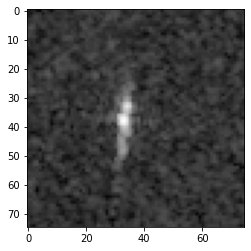

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[1800], cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
#rescaling intensity to range [0,1] and converting to 8bit int

bin_width = 32

X_scaled = exposure.rescale_intensity(images, out_range=(0,1))
X_binned = util.img_as_ubyte(X_scaled)
X_binned = X_binned // bin_width
X_binned.shape, X_scaled.shape

((3208, 75, 75), (3208, 75, 75))

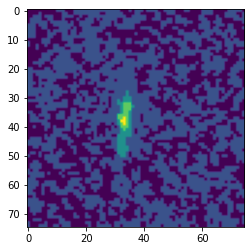

In [ ]:
plt.imshow(X_binned[1800])

In [ ]:
train_idx = np.random.choice(len(YTrain), round(len(YTrain)*0.8), replace=False)
val_idx = np.array(list(set(range(len(YTrain))) - set(train_idx)))

In [ ]:
val_idx.shape

(642,)

In [ ]:
X_train = X_binned[train_idx]
X_val = X_binned[val_idx]
Y_train = YTrain[train_idx]
Y_val = YTrain[val_idx]
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((2566, 75, 75), (642, 75, 75), (2566,), (642,))

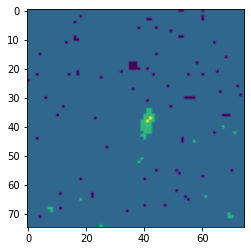

In [ ]:
plt.imshow(X_train[0])

In [ ]:
##Feature extraction using Gray-Level Co-Occurrence Matrix (GLCM)

def GLCM_feature_extraction(data):
  image_df = pd.DataFrame()

  for img in range(data.shape[0]):
    df = pd.DataFrame()
    image = data[img, :,:]

    GLCM = greycomatrix(image, [1], [0])
    GLCM_energy = greycoprops(GLCM, "energy")[0]
    df["Energy"] = GLCM_energy
    GLCM_corr = greycoprops(GLCM, "correlation")[0]
    df["Correlation"] = GLCM_corr
    GLCM_diss = greycoprops(GLCM, "dissimilarity")[0]
    df["Dissimilarity"] = GLCM_diss
    GLCM_homgen = greycoprops(GLCM, "homogeneity")[0]
    df["Homogenity"] = GLCM_homgen
    GLCM_cont = greycoprops(GLCM, "contrast")[0]
    df["Contrast"] = GLCM_cont
    
    GLCM2 = greycomatrix(image, [3], [0])
    GLCM_energy2 = greycoprops(GLCM2, "energy")[0]
    df["Energy2"] = GLCM_energy2
    GLCM_corr2 = greycoprops(GLCM2, "correlation")[0]
    df["Correlation2"] = GLCM_corr2
    GLCM_diss2 = greycoprops(GLCM2, "dissimilarity")[0]
    df["Dissimilarity2"] = GLCM_diss2
    GLCM_homgen2 = greycoprops(GLCM2, "homogeneity")[0]
    df["Homogeneity2"] = GLCM_homgen2
    GLCM_cont2 = greycoprops(GLCM2, "contrast")[0]
    df["Contrast2"] = GLCM_cont2
    
    # GLCM 3
    GLCM3 = greycomatrix(image, [5], [0])
    GLCM_energy = greycoprops(GLCM3, "energy")[0]
    df["Energy3"] = GLCM_energy
    GLCM_corr3 = greycoprops(GLCM3, "correlation")[0]
    df["Correlation3"] = GLCM_corr3
    GLCM_diss3 = greycoprops(GLCM3, "dissimilarity")[0]
    df["Dissimilarity3"] = GLCM_diss3
    GLCM_homgen3 = greycoprops(GLCM3, "homogeneity")[0]
    df["Homogeneity3"] = GLCM_homgen3
    GLCM_cont3 = greycoprops(GLCM3, "contrast")[0]
    df["Contrast3"] = GLCM_cont3
    
    # GLCM 4
    GLCM4 = greycomatrix(image, [0], [np.pi/4])
    GLCM_energy4 = greycoprops(GLCM4, "energy")[0]
    df["Energy4"] = GLCM_energy4
    GLCM_corr4 = greycoprops(GLCM4, "correlation")[0]
    df["Correlation4"] = GLCM_corr4
    GLCM_diss4 = greycoprops(GLCM4, "dissimilarity")[0]
    df["Dissimilarity4"] = GLCM_diss4
    GLCM_homgen4 = greycoprops(GLCM4, "homogeneity")[0]
    df["Homogeneity4"] = GLCM_homgen4
    GLCM_cont4 = greycoprops(GLCM4, "contrast")[0]
    df["Contrast4"] = GLCM_cont4
    
    # GLCM 5
    GLCM5 = greycomatrix(image, [0], [np.pi/4])
    GLCM_energy5 = greycoprops(GLCM5, "energy")[0]
    df["Energy5"] = GLCM_energy5
    GLCM_corr5 = greycoprops(GLCM5, "correlation")[0]
    df["Correlation5"] = GLCM_corr5
    GLCM_diss5 = greycoprops(GLCM5, "dissimilarity")[0]
    df["Dissimilarity5"] = GLCM_diss5
    GLCM_homgen5 = greycoprops(GLCM5, "homogeneity")[0]
    df["Homogeneity5"] = GLCM_homgen5
    GLCM_cont5 = greycoprops(GLCM5, "contrast")[0]
    df["Contrast5"] = GLCM_cont5

    # Append all features into img_ds
    image_df = image_df.append(df)

  return image_df

In [ ]:
X_train_features = GLCM_feature_extraction(X_train)
X_val_features = GLCM_feature_extraction(X_val)

In [ ]:
# append train angles to the dataset
X_train_features["INC_ANGLE"] = train_angles[train_idx]
X_val_features["INC_ANGLE"] = train_angles[val_idx]

In [ ]:
X_train_features.head()

,Energy,Correlation,Dissimilarity,Homogenity,Contrast,Energy2,Correlation2,Dissimilarity2,Homogeneity2,Contrast2,...,Correlation4,Dissimilarity4,Homogeneity4,Contrast4,Energy5,Correlation5,Dissimilarity5,Homogeneity5,Contrast5,INC_ANGLE
0,0.606660,0.612538,0.220180,0.889910,0.220180,0.544327,0.254152,0.418333,0.791537,0.425370,...,1.0,0.0,1.0,0.0,0.729151,1.0,0.0,1.0,0.0,0.649256
0,0.955487,0.575355,0.032973,0.983514,0.032973,0.949123,0.332476,0.048704,0.976056,0.052778,...,1.0,0.0,1.0,0.0,0.971211,1.0,0.0,1.0,0.0,0.742809
0,0.561194,0.422190,0.292252,0.853874,0.292252,0.521185,0.108470,0.450000,0.775111,0.451111,...,1.0,0.0,1.0,0.0,0.720321,1.0,0.0,1.0,0.0,0.644372
0,0.924466,0.468546,0.055315,0.972342,0.055315,0.913610,0.204353,0.079815,0.960426,0.083148,...,1.0,0.0,1.0,0.0,0.951494,1.0,0.0,1.0,0.0,0.742910
0,0.914984,0.742485,0.064324,0.968486,0.070811,0.896475,0.309382,0.127222,0.943130,0.194630,...,1.0,0.0,1.0,0.0,0.939397,1.0,0.0,1.0,0.0,0.776368


In [ ]:
# Training 

### Training

#### RandomForest

In [ ]:
##Random Forest (BASE model)

In [ ]:
rfm= RandomForestClassifier(
    n_estimators=100, random_state=23,)
rfm.fit(X_train_features, Y_train)

RandomForestClassifier(random_state=23)

In [ ]:
y_pred = rfm.predict(X_val_features)
rand_acc = accuracy_score(Y_val, y_pred)
rand_acc

0.7663551401869159

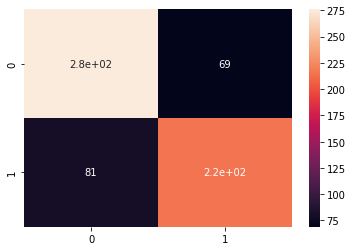

In [ ]:
import seaborn as sns
cm = confusion_matrix(Y_val, y_pred.round())
sns.heatmap(cm, annot=True)

In [ ]:
print (classification_report(Y_val, y_pred.round()))

              precision    recall  f1-score   support

           0       0.77      0.80      0.79       345
           1       0.76      0.73      0.74       297

    accuracy                           0.77       642
   macro avg       0.77      0.76      0.76       642
weighted avg       0.77      0.77      0.77       642



In [ ]:
## XGBoost

#### XGBoost

In [ ]:
# for more on hyperparameter tunning and xgboost parameter search
# https://www.kaggle.com/code/prashant111/bayesian-optimization-using-hyperopt/notebook
# https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook


In [ ]:
parameters_space = {
    'max_depth': hp.quniform('max_depth', 3, 25, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 20, 1),
    'n_estimators': hp.choice('n_estimators', [50, 75, 100, 125, 150, 200]), 
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2), 'seed': 0, }

In [ ]:
def objective(space):
  clf = XGBClassifier(
      n_estimators = space['n_estimators'],
      max_depth = int(space['max_depth']),
      learning_rate = space['learning_rate'],
      gamma = space['gamma'],
      reg_alpha = int(space['reg_alpha']),
      min_child_weight= int(space['min_child_weight']),
      colsample_bytree = int(space['colsample_bytree']),)
      #tree_method = 'gpu_hist',)
  
  evaluation = [(X_train_features, Y_train), (X_val_features, Y_val)]
  clf.fit(
      X_train_features, Y_train, eval_metric='auc',
      eval_set=evaluation, early_stopping_rounds=10, verbose=False,)
  
  pred = clf.predict(X_val_features)
  acc = accuracy_score(Y_val, pred>0.5)
  
  print (f'SCORE: {acc}')
  return {'loss' : -acc, 'status': STATUS_OK}

In [ ]:
trials = Trials()

best_hyperparms = fmin(
    fn=objective, space=parameters_space,
    algo=tpe.suggest, max_evals=150, trials=trials,)


In [ ]:
print (best_hyperparms)

{'colsample_bytree': 0.7434680236499209, 'gamma': 8.62784410559131, 'learning_rate': 0.155481867661696, 'max_depth': 12.0, 'min_child_weight': 20.0, 'n_estimators': 2, 'reg_alpha': 40.0, 'reg_lambda': 0.6946303862582032}


In [ ]:

params = {'colsample_bytree': 0.7434680236499209, 'gamma': 8.62784410559131, 'learning_rate': 0.155481867661696, 'max_depth': 12, 'min_child_weight': 20, 'n_estimators': 2, 'reg_alpha': 40, 'reg_lambda': 0.6946303862582032}
clf = XGBClassifier(**params)
  
evaluation = [(X_train_features, Y_train), (X_val_features, Y_val)]
clf.fit(
    X_train_features, Y_train, eval_metric='auc',
    eval_set=evaluation, early_stopping_rounds=10, verbose=False,)

pred = clf.predict(X_val_features)
acc = accuracy_score(Y_val, pred)

In [ ]:
acc = accuracy_score(Y_val, pred)
acc

0.6651090342679128

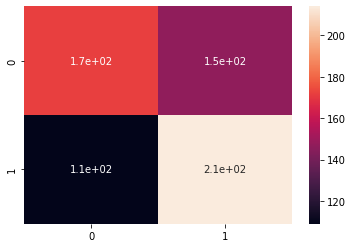

In [ ]:
import seaborn as sns
cm = confusion_matrix(Y_val, pred.round())
sns.heatmap(cm, annot=True)

In [ ]:
print (classification_report(Y_val, y_pred.round()))

              precision    recall  f1-score   support

           0       0.72      0.82      0.77       319
           1       0.79      0.69      0.74       323

    accuracy                           0.75       642
   macro avg       0.76      0.75      0.75       642
weighted avg       0.76      0.75      0.75       642



#### LightGBM

In [ ]:
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train_features, label=Y_train)
lgb_val = lgb.Dataset(X_val_features, label=Y_val)

In [ ]:
lgb_parameter_space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "num_leaves": hp.choice("num_leaves", [15, 31, 63, 127, 255]),
    "max_depth": hp.choice("max_depth", [-1, 4, 6, 8, 10]),
    "feature_fraction": hp.quniform("feature_fraction", .5, .9, 0.1),
    "bagging_fraction": hp.quniform("bagging_fraction", .5, .9, 0.1),
    "min_child_samples": hp.choice('min_child_samples', [10, 25, 100]),
    "lambda_l1": hp.choice('lambda_l1', [0, .1, 1, 10]),
    "lambda_l2": hp.choice('lambda_l2', [0, .1, 1, 10]),}

lgb_params = {'boosting_type':'gbdt', 'objective':'binary',
      'metric':'auc', 'num_class':1}


In [ ]:

def lgbm_objectvie(lgbm_space):
  clf = lgb.train(
      lgb_params, train_set=lgb_train, 
      num_boost_round=300, valid_sets=lgb_val,
      early_stopping_rounds=45, verbose_eval=0)
  
  score = clf.best_score['valid_0'][lgb_params['metric']]

  return {'loss': -score, 'status': STATUS_OK, 'model': clf}

In [ ]:
import hyperopt
trials = Trials()
best = hyperopt.fmin(
    fn=lgbm_objectvie, space=lgb_parameter_space, trials=trials,
    algo=tpe.suggest, max_evals=150, verbose=1,
    rstate=np.random.RandomState(23))

hyperparams = space_eval(lgb_parameter_space, best)
print (hyperparams)

In [ ]:
hyperparams = space_eval(lgb_parameter_space, best)
print (hyperparams)

{'bagging_fraction': 0.6000000000000001, 'feature_fraction': 0.9, 'lambda_l1': 0, 'lambda_l2': 0.1, 'learning_rate': 0.2360857587653838, 'max_depth': 4, 'min_child_samples': 100, 'num_leaves': 255}


In [ ]:
hyperparams.update({
    "metric": "auc"})
hyperparams

In [ ]:
lgb_clf = lgb.train(
      hyperparams, train_set=lgb_train, 
      num_boost_round=300, valid_sets=lgb_val,
      early_stopping_rounds=45, verbose_eval=0)
  
score = lgb_clf.best_score['valid_0'][lgb_params['metric']]
print (score)

0.9467330307910018


[0.32588269614722115, 0.8691588785046729, 0.8402555910543131, 0.8855218855218855]


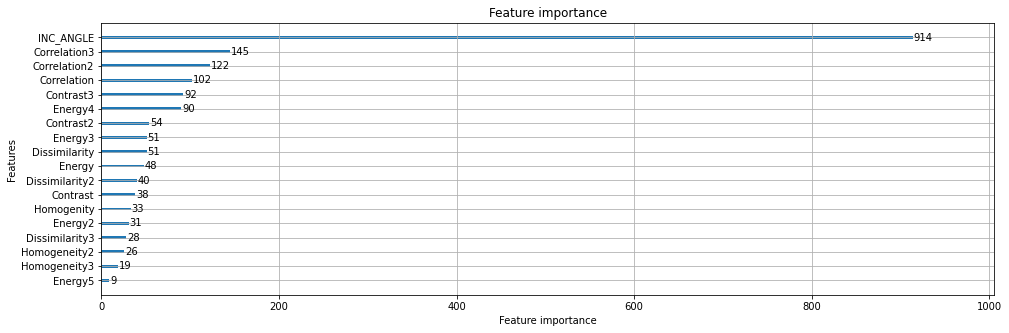

In [ ]:
predict_y_proba_gbm = lgb_clf.predict(X_val_features, num_iteration=lgb_clf.best_iteration)
predict_y_gbm = np.where(predict_y_proba_gbm.reshape((predict_y_proba_gbm.shape[0])) > 0.5, 1, 0)

score_ll = log_loss(Y_val, predict_y_proba_gbm)
score_ac = accuracy_score(Y_val, predict_y_gbm)
score_pr = precision_score(Y_val, predict_y_gbm)
score_re = recall_score(Y_val, predict_y_gbm)
score = [score_ll, score_ac, score_pr, score_re]
print (score)

import matplotlib.pyplot as plt
#if (importance == True):
ax = lgb.plot_importance(lgb_clf, max_num_features=20, figsize=(16, 5))
plt.show()

gbmDF = pd.DataFrame([tuple(lgb_clf.feature_importance())], columns= lgb_clf.feature_name())
gbmDF.sort_index(axis=1, inplace=True)

In [ ]:
predict_y_gbm

In [ ]:
lgb_class = lgb.LGBMClassifier(**hyperparams)

lgb_class.fit(X_train_features, Y_train)
lgb_cls_pred = lgb_class.predict(X_val_features)#, label=Y_val

In [ ]:
score_ll = log_loss(Y_val, lgb_cls_pred)
score_ac = accuracy_score(Y_val, lgb_cls_pred)
score_pr = precision_score(Y_val, lgb_cls_pred)
score_re = recall_score(Y_val, lgb_cls_pred)
score = [score_ll, score_ac, score_pr, score_re]
print (score)

[6.025534783283643, 0.8255451713395638, 0.797427652733119, 0.835016835016835]


#### CNN

In [ ]:
#CNN
## Functional API with Keras

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Input, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3, Xception
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


In [ ]:
params = {'img_shape': 75, 'activation': 'relu', 'batch_size': 32}
inputs = Input(shape=(params['img_shape'], params['img_shape'], 3))

# Layer 1
conv2D = layers.Conv2D(64, kernel_size=(3,3), activation=params['activation'],\
              input_shape=(params['img_shape'], params['img_shape'], 3))(inputs)
maxPool2D = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))(conv2D)
dropout = layers.Dropout(0.2)(maxPool2D)

# Layer 2
conv2D_2 = layers.Conv2D(128, kernel_size=(3,3), activation='relu')(dropout)
maxPool2D_2 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv2D_2)
dropout_2 = layers.Dropout(0.2)(maxPool2D_2)

# Layer 3
conv2D_3 = layers.Conv2D(128, kernel_size=(3,3), activation='relu')(dropout_2)
maxPool2D_3 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv2D_3)
dropout_3 = layers.Dropout(0.2)(maxPool2D_3)

#Layer 4
conv2D_4 = layers.Conv2D(128, kernel_size=(3,3), activation='relu')(dropout_3)
maxPool2D_4 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv2D_4)
dropout_4 = layers.Dropout(0.2)(maxPool2D_4)

flatten = layers.Flatten()(dropout_4)
dense = layers.Dense(512, activation='relu')(flatten)
dropout_5 = layers.Dropout(0.2)(dense)

dense_2 = layers.Dense(256, activation='relu')(dropout_5)
dropout_6 = layers.Dropout(0.2)(dense_2)

outputs = layers.Dense(1, activation='sigmoid')(dropout_6)

model = Model(inputs=inputs, outputs=outputs, name='iceberg')
model.summary()

Model: "iceberg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 73, 73, 64)        1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 36, 36, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 17, 17, 128)      0         
 2D)                                                       

In [ ]:
optimizer = Adam()
model.compile(
    optimizer=optimizer, loss='binary_crossentropy',
    metrics=['accuracy'])

ES = EarlyStopping(
    'val_loss', patience=5, mode='min')

chk_pnt = ModelCheckpoint(
    '.iceberg.hdf5', save_best_only=True)

callbacks = [ES, chk_pnt]

In [ ]:
X_train_features,X_val_features, Y_train, Y_val = train_test_split(XTrain, YTrain, train_size=0.8, shuffle=True, random_state=23)

history = model.fit(
    X_train_features, Y_train,
    batch_size=32,
    epochs=50,
    verbose=1,
    validation_data=(X_val_features, Y_val))

Epoch 1/50
81/81 [==============================] - 119s 1s/step - loss: 0.2525 - accuracy: 0.8924 - val_loss: 0.2709 - val_accuracy: 0.8925
Epoch 2/50
81/81 [==============================] - 83s 1s/step - loss: 0.2408 - accuracy: 0.8967 - val_loss: 0.2969 - val_accuracy: 0.8801
Epoch 3/50
81/81 [==============================] - 87s 1s/step - loss: 0.2242 - accuracy: 0.9041 - val_loss: 0.3156 - val_accuracy: 0.8801
Epoch 4/50
81/81 [==============================] - 83s 1s/step - loss: 0.2165 - accuracy: 0.9072 - val_loss: 0.2796 - val_accuracy: 0.8941
Epoch 5/50
81/81 [==============================] - 83s 1s/step - loss: 0.2444 - accuracy: 0.8991 - val_loss: 0.2727 - val_accuracy: 0.8847
Epoch 6/50
81/81 [==============================] - 85s 1s/step - loss: 0.2004 - accuracy: 0.9174 - val_loss: 0.2775 - val_accuracy: 0.8832
Epoch 7/50
81/81 [==============================] - 82s 1000ms/step - loss: 0.1996 - accuracy: 0.9150 - val_loss: 0.2480 - val_accuracy: 0.9034
Epoch 8/50
81/8

In [ ]:
model.save('iceberg')

In [ ]:
model.evaluate(X_val_features, y_val)

21/21 [==============================] - 1s 19ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [ ]:
model.load_weights(filepath='iceberg.hdf5')
scr = model.evaluate(X_val_features, Y_val, verbose=1)
print (f"Loss: {scr[0]};; acc: {scr[1]}")

In [ ]:
cnn_pred_test = model.predict_proba(XTest)

In [ ]:
cnn_sub = pd.DataFrame(
    {
        "id": sub['id'],
        "is_iceberg": cnn_pred_test
    }
)
cnn_sub.to_csv('cnn_sub.csv', index=False)

(8424, 75, 75, 3)

### Testing and Submission

In [ ]:
## Testing

In [ ]:
rgb_weights = [0.2989, 0.5870, 0.1140] #Intensity to conver to greyscale
test_images = np.dot(XTest[...,:3], rgb_weights)
test_images.shape

(8424, 75, 75)

In [ ]:
#rescaling intensity to range [0,1] and converting to 8bit int

bin_width = 32

test_scaled = exposure.rescale_intensity(test_images, out_range=(0,1))
test_binned = util.img_as_ubyte(test_scaled)
test_binned = test_binned // bin_width
test_binned.shape, test_scaled.shape

((8424, 75, 75), (8424, 75, 75))

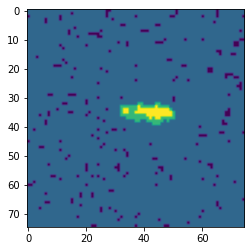

In [ ]:
plt.imshow(test_binned[1800])

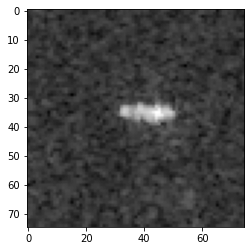

In [ ]:
plt.imshow(test_images[1800], cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
test_GLMC_features = GLCM_feature_extraction(test_binned)
test_GLMC_features['INC_ANGLE'] = test_angle
test_GLMC_features.head()

,Energy,Correlation,Dissimilarity,Homogenity,Contrast,Energy2,Correlation2,Dissimilarity2,Homogeneity2,Contrast2,...,Correlation4,Dissimilarity4,Homogeneity4,Contrast4,Energy5,Correlation5,Dissimilarity5,Homogeneity5,Contrast5,INC_ANGLE
0,0.919080,0.270738,0.067748,0.966126,0.067748,0.908461,0.035843,0.090000,0.955000,0.090000,...,1.0,0.0,1.0,0.0,0.952744,1.0,0.0,1.0,0.0,0.610279
0,0.628533,0.396804,0.254775,0.872649,0.255135,0.601356,0.207082,0.333889,0.833278,0.336111,...,1.0,0.0,1.0,0.0,0.764065,1.0,0.0,1.0,0.0,0.569240
0,0.437618,0.747022,0.309730,0.845676,0.315135,0.406993,0.641024,0.413889,0.796511,0.448704,...,1.0,0.0,1.0,0.0,0.589440,1.0,0.0,1.0,0.0,0.654593
0,0.933668,0.500385,0.044505,0.977748,0.044505,0.920981,0.189694,0.071296,0.964463,0.072407,...,1.0,0.0,1.0,0.0,0.956088,1.0,0.0,1.0,0.0,0.601683
0,0.539286,0.173616,0.393514,0.803279,0.393874,0.531140,0.066188,0.441852,0.779481,0.445926,...,1.0,0.0,1.0,0.0,0.727557,1.0,0.0,1.0,0.0,0.766529


In [ ]:
sub_path = "/content/gdrive/MyDrive/Kaggle/sample_submission.csv.7z"
file = py7zr.SevenZipFile(sub_path, mode='r')
file.extractall('.')

sub = pd.read_csv("/content/data/processed/sample_submission.csv")
sub.head()

,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.5
2,b20200e4,0.5
3,e7f018bb,0.5
4,4371c8c3,0.5


In [ ]:
# xgboost submission

#### XGB Sub

In [ ]:
xgb_test_pred = clf.predict_proba(test_GLMC_features)
xgb_proba = list(np.max(xgb_test_pred, axis=1))
xgb_sub = pd.DataFrame(
    {'id': sub['id'],
    'is_iceberg': xgb_proba}
)
xgb_sub.to_csv('xgb_sub.csv', index=False)

#### Random Forest Sub

In [ ]:
## random forest submission
rand_test_pred = rfm.predict_proba(test_GLMC_features)
rand_test_pred

array([[0.31, 0.69],
       [0.27, 0.73],
       [0.77, 0.23],
       ...,
       [0.58, 0.42],
       [0.09, 0.91],
       [0.25, 0.75]])

In [ ]:
rand_proba = list(np.max(rand_test_pred, axis=1))
rand_sub = pd.DataFrame(
    {
        "id": sub['id'],
        "is_iceberg": rand_proba
    }
)

rand_sub.head()

,id,is_iceberg
0,5941774d,0.69
1,4023181e,0.73
2,b20200e4,0.77
3,e7f018bb,0.76
4,4371c8c3,0.62


In [ ]:
rand_sub.to_csv('rand_sub.csv', index=False)

#### LightGBM sub

In [ ]:
## lgb submission
lgb_test_pred = lgb_clf.predict(test_GLMC_features)
lgb_test_pred

array([ 0.51738735,  0.88548663, -0.05836222, ..., -0.01992477,
        0.87906252,  0.91434491])

In [ ]:
lgb_cls_proba = lgb_class.predict_proba(test_GLMC_features)[:, 1]
lgb_sub = pd.DataFrame(
    {
        "id": sub['id'],
        "is_iceberg": lgb_cls_proba
    }
)
lgb_sub.to_csv('lgb_sub.csv', index=False)